In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
import pingouin as pg

In [3]:
data = pd.read_csv('~/Desktop/columbia/capstone/fire-regimes/data/merged_output.csv').drop(columns=['id1','id2','time','x','y'])

df_dedup = data.groupby(['source_file','level'], as_index=False).mean()
df_pivoted = df_dedup.set_index(['source_file', 'level']).unstack('level')
df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]

X = df_pivoted[~np.isnan(df_pivoted).any(axis=1)]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

### Load in data for torch

### An AutoEncoder Class with dynamic latent dimension

In [17]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(174, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, latent_dim)  # Use latent_dim here
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64),  # Start with latent_dim here
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 174)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
def train_model(model,train_loader,n_epochs,optimizer,loss_function):

  losses = []

  for _ in range(n_epochs):
    for profile in train_loader:
        
      # Output of Autoencoder
      reconstructed = model(profile)
        
      # Calculating the loss function
      loss = loss_function(reconstructed, profile)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      losses.append(loss.item())
  
  return (model,losses)

In [31]:
def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_loss(losses,window_size):
    loss_floats = [loss for loss in losses]
    smoothed_losses = rolling_average(loss_floats, window_size)
    plt.plot(smoothed_losses)
    plt.show()

In [25]:
latent_dims = [4,6,8,12,16,24,32,48]
results = []

for i,latent_dim in enumerate(latent_dims):
    fold_losses = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kf.split(train_data):
        # Split data
        train_subset = torch.utils.data.Subset(train_data, train_idx)
        val_subset = torch.utils.data.Subset(train_data, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize model, optimizer, and loss function for this fold
        model = AutoEncoder(latent_dim=latent_dim)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-8)
        loss_function = torch.nn.MSELoss()

        # Train model and get average training loss for the fold
        avg_train_loss = train_model(model, train_loader=train_loader, n_epochs=2, optimizer=optimizer, loss_function=loss_function)

        model.eval()
        val_losses = []
        with torch.no_grad():
            for profile in val_loader:
                reconstructed = model(profile)
                val_loss = loss_function(reconstructed, profile)
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        fold_losses.append(avg_val_loss)

    # Record average validation loss for this latent dimension
    results.append(np.mean(fold_losses))
    print(f"Latent Dim: {latent_dim}, Avg Validation Loss: {results[i]}")

Latent Dim: 4, Avg Validation Loss: 0.35960532584777016
Latent Dim: 6, Avg Validation Loss: 0.27098767601353135
Latent Dim: 8, Avg Validation Loss: 0.23185654756398605
Latent Dim: 12, Avg Validation Loss: 0.2170932384977581
Latent Dim: 16, Avg Validation Loss: 0.19318075669394685
Latent Dim: 24, Avg Validation Loss: 0.1696244248973458
Latent Dim: 32, Avg Validation Loss: 0.1978144393311314
Latent Dim: 48, Avg Validation Loss: 0.1978299817264268


In [28]:
train_data = torch.from_numpy(X).float()
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=64, shuffle=True)

In [33]:
model = AutoEncoder(latent_dim=16)
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.01,
                             weight_decay = 1e-8)

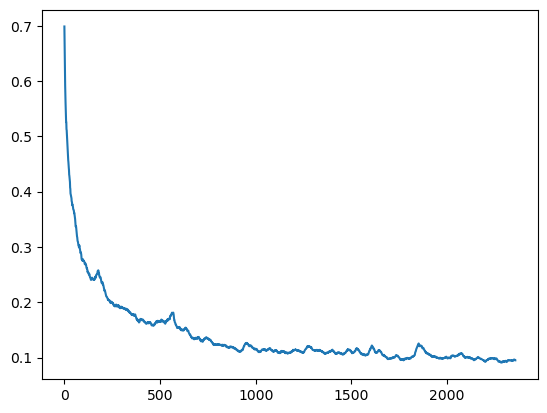

In [34]:
model,losses = train_model(model,n_epochs=3,train_loader=train_loader,loss_function=loss_function,optimizer=optimizer)
plot_loss(losses=losses,window_size=20)

In [35]:
r = model(train_data).detach().numpy()
train = train_data.numpy()
l = model.encoder(train_data).detach().numpy()

In [ ]:
#np.save('../data/latent-16.npy',l)

In [38]:
full_pca = decomposition.PCA(n_components=16)
full_pca.fit(l)

explained_variance = full_pca.explained_variance_ratio_

In [ ]:
plt.plot(explained_variance)

In [2]:
l = np.load("../data/latent-16.npy")
mardia_test = pg.multivariate_normality(l, alpha=0.05)
print(mardia_test)

HZResults(hz=5.413242806401451, pval=0.0, normal=False)


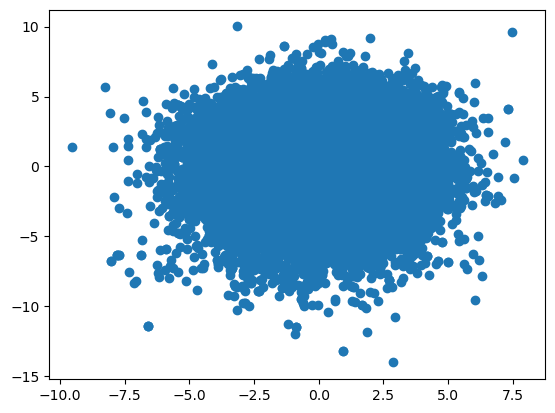

In [14]:
plt.scatter(l[:,2],l[:,12])

In [ ]:
import seaborn as sns
sns.pairplot(pd.DataFrame(l))